# Univariate Time Series

# 1. Import Library
## Mengimpor semua pustaka yang diperlukan untuk analisis data, normalisasi, dan pembuatan model LSTM.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
import os
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 2. Load Dataset

In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/d/sumanthvrao/daily-climate-time-series-data/DailyDelhiClimateTrain.csv
/kaggle/input/d/sumanthvrao/daily-climate-time-series-data/DailyDelhiClimateTest.csv
/kaggle/input/daily-climate-time-series-data/data


In [5]:
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv("/kaggle/input/d/sumanthvrao/daily-climate-time-series-data/DailyDelhiClimateTrain.csv")
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [6]:
df.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [7]:
df.dtypes

date             object
meantemp        float64
humidity        float64
wind_speed      float64
meanpressure    float64
dtype: object

In [8]:
df.shape

(1462, 5)

## Membaca data CSV dan mengubah kolom date menjadi tipe datetime.

In [9]:
df['date'] = pd.to_datetime(df['date'])

In [10]:
dates = df['date'].values
temp  = df['meantemp'].values

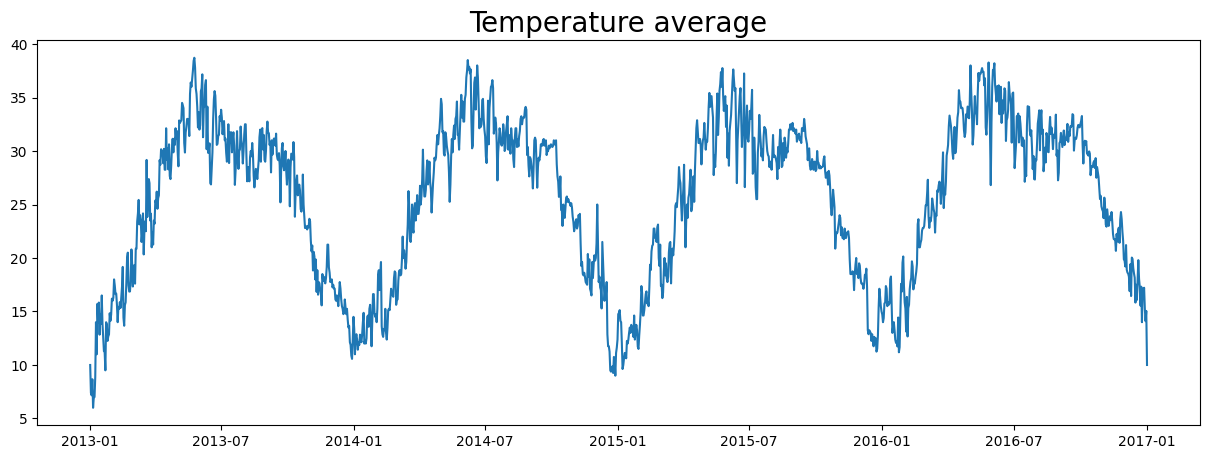

In [11]:
plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Temperature average',
          fontsize=20);

In [12]:
target_column = 'meantemp'

In [13]:
train_series = df[target_column].values

# Normalisasi Data

In [15]:
scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train_series.reshape(-1, 1)).flatten()

# Membuat Dataset Berjendela
Membuat dataset dalam bentuk jendela dengan window_size=60 (60 hari terakhir digunakan untuk prediksi).

In [17]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift = 1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w:(w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [18]:
window_size = 60
batch_size = 32
shuffle_buffer = 1000

# Membangun Model LSTM

Layer LSTM untuk memproses data sekuensial.

Dropout untuk mencegah overfitting.

Dense Layer untuk regresi suhu.

In [19]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=[window_size, 1]),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

## Kompilasi Model

Menggunakan Adam optimizer dengan learning rate 0.001.

Mean Squared Error (MSE) digunakan sebagai loss function.

In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['mae']
)

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

## Menambahkan Callbacks

EarlyStopping menghentikan pelatihan jika tidak ada peningkatan.

ModelCheckpoint menyimpan model terbaik.

ReduceLROnPlateau mengurangi learning rate jika model tidak membaik.

In [22]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_lstm_model.keras', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr= 0.0001)
]

# save H5 FILE NOT KERAS

## Mengubah dataset kedalam bentuk windowed

In [24]:
train_dataset = windowed_dataset(
    train_scaled, 
    window_size, 
    batch_size, 
    shuffle_buffer
)

# Training Model
## Training model dengan dataset yang sudah diubah ke bentuk windowed.


In [25]:
history = model.fit(
    train_dataset,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0877 - mae: 0.2217 - learning_rate: 0.0010
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0131 - mae: 0.0897 - learning_rate: 0.0010
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0113 - mae: 0.0849 - learning_rate: 0.0010
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0094 - mae: 0.0757 - learning_rate: 0.0010
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0092 - mae: 0.0750 - learning_rate: 0.0010
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0092 - mae: 0.0762 - learning_rate: 0.0010
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0076 - mae: 0.0691 - learning_rate: 0.0010
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0072 - mae: 0.0671 - learning_rate: 0.0010
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0075 - mae: 0.0678 - learning_rate: 0.0010
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - 

In [26]:
def windowed_dataset_eval(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.map(lambda w:(w[:-1], w[-1:]))
    return ds.batch(1)

In [28]:
train_eval_dataset = windowed_dataset_eval(train_scaled, window_size)
train_predictions = model.predict(train_eval_dataset)
train_predictions = scaler.inverse_transform(train_predictions)

1402/1402 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step


In [30]:
actual_train = train_series[window_size:window_size+len(train_predictions)]

train_rmse = np.sqrt(mean_squared_error(actual_train, train_predictions))
train_mae = mean_absolute_error(actual_train, train_predictions)
train_r2 = r2_score(actual_train, train_predictions)

print("\nMetrik Evaluasi Model:")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Train R²: {train_r2:.4f}")


Metrik Evaluasi Model:
Train RMSE: 1.6159
Train MAE: 1.2591
Train R²: 0.9480


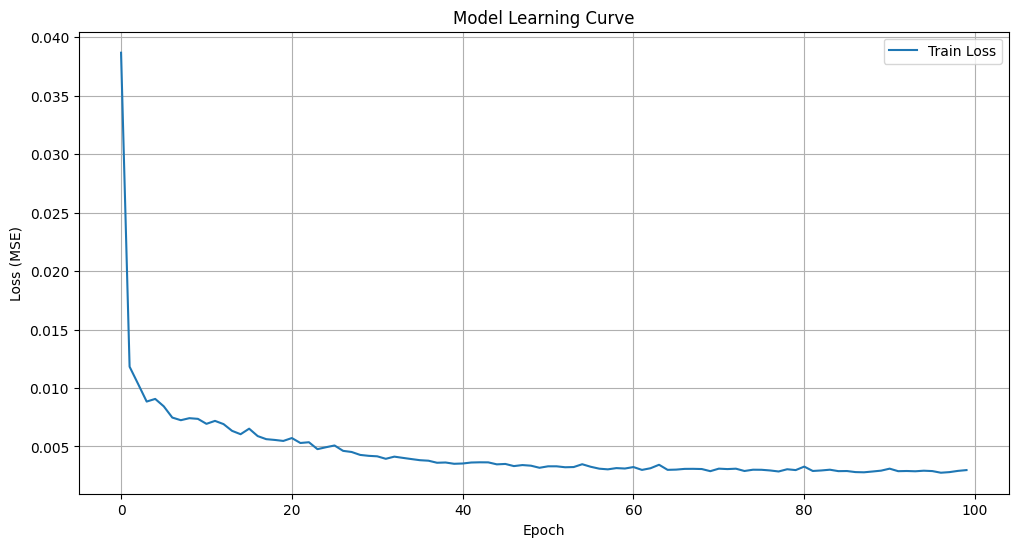

In [31]:
# Visualisasi Learning Curve
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Model Learning Curve')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

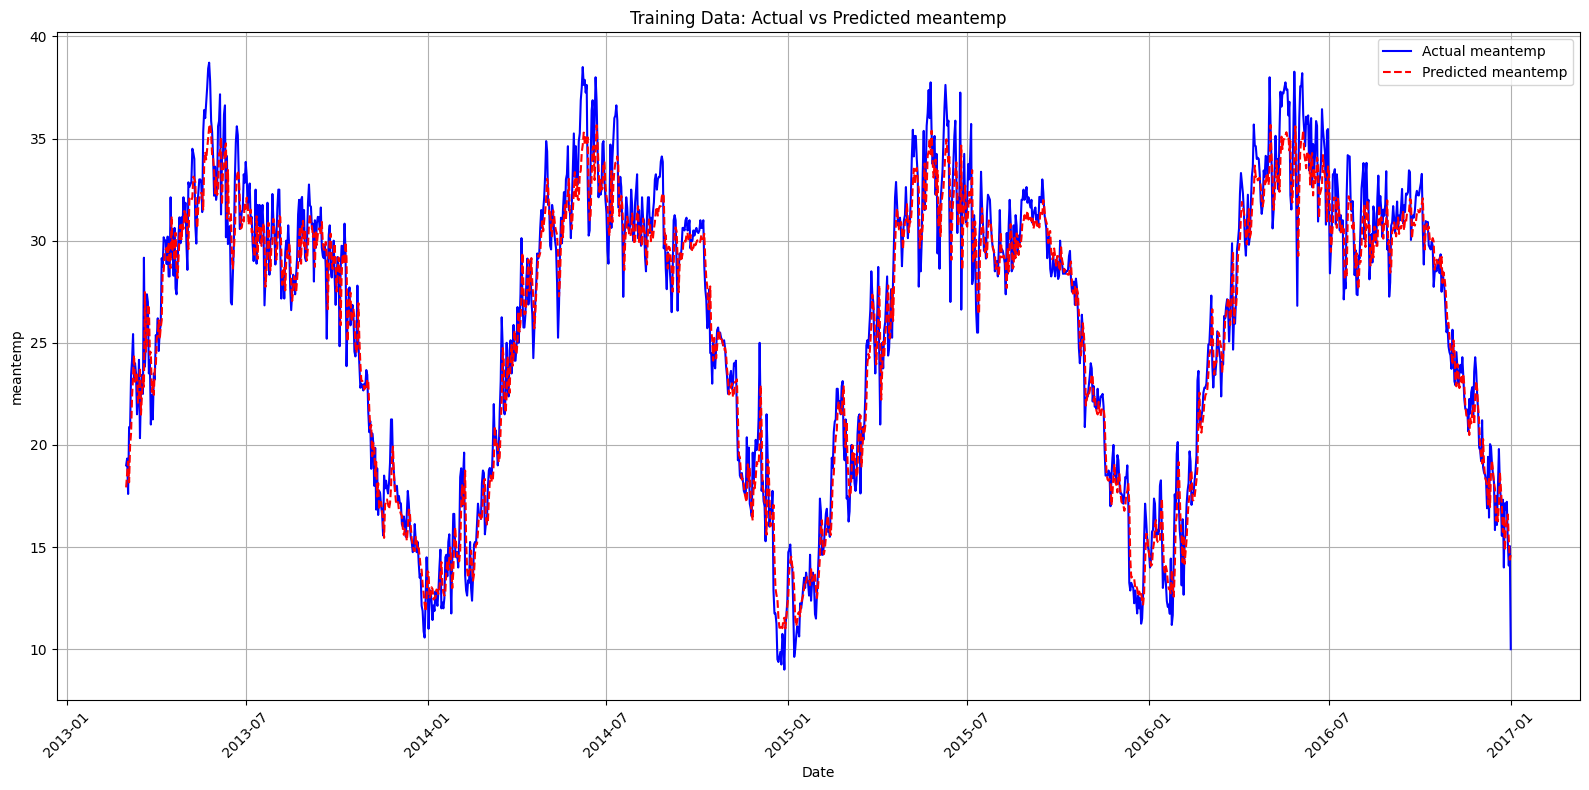

In [32]:
train_dates = df['date'].iloc[window_size:window_size+len(train_predictions)].reset_index(drop=True)

plt.figure(figsize=(16, 8))
plt.plot(train_dates, actual_train, label=f'Actual {target_column}', color='blue')
plt.plot(train_dates, train_predictions, label=f'Predicted {target_column}', color='red', linestyle='--')
plt.title(f'Training Data: Actual vs Predicted {target_column}')
plt.xlabel('Date')
plt.ylabel(target_column)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

===================================

In [33]:
import warnings
warnings.filterwarnings('ignore')
test_df = pd.read_csv("/kaggle/input/d/sumanthvrao/daily-climate-time-series-data/DailyDelhiClimateTest.csv")
test_df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [34]:
test_series = test_df['meantemp'].values
test_scaled = scaler.transform(test_series.reshape(-1, 1)).flatten()

In [35]:
test_dataset = windowed_dataset_eval(test_scaled, window_size)
test_predictions = model.predict(test_dataset)
test_predictions = scaler.inverse_transform(test_predictions)

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [37]:
actual_test = test_series[window_size:window_size+len(test_predictions)]

test_rmse = np.sqrt(mean_squared_error(actual_test, test_predictions))
test_mae = mean_absolute_error(actual_test, test_predictions)
test_r2 = r2_score(actual_test, test_predictions)

print("\nMetrik Evaluasi Model:")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R²: {test_r2:.4f}")


Metrik Evaluasi Model:
Test RMSE: 1.6213
Test MAE: 1.2952
Test R²: 0.8942


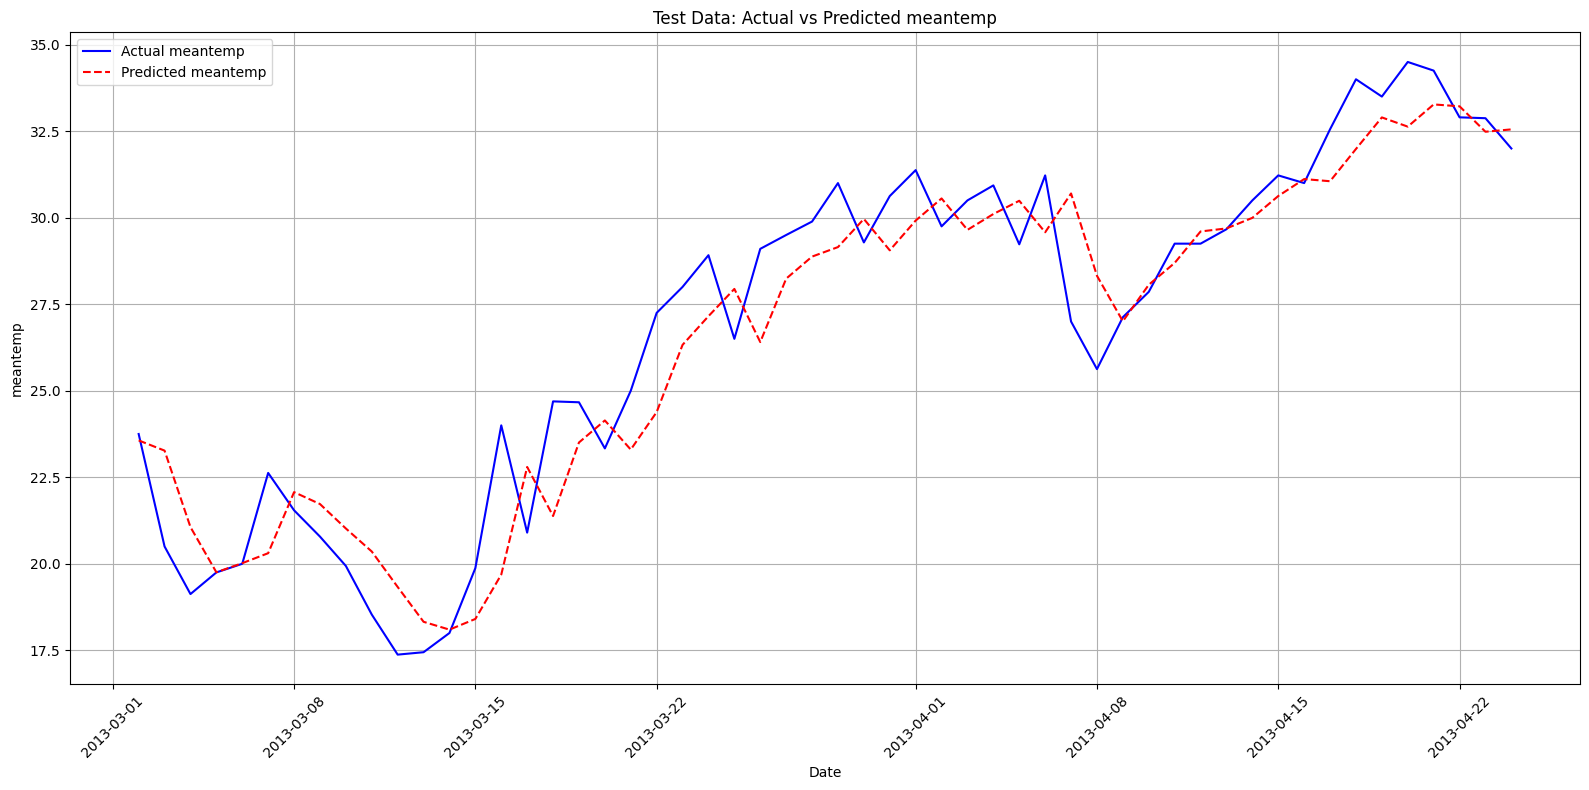

In [38]:
test_dates = df['date'].iloc[window_size:window_size+len(test_predictions)].reset_index(drop=True)

plt.figure(figsize=(16, 8))
plt.plot(test_dates, actual_test, label=f'Actual {target_column}', color='blue')
plt.plot(test_dates, test_predictions, label=f'Predicted {target_column}', color='red', linestyle='--')
plt.title(f'Test Data: Actual vs Predicted {target_column}')
plt.xlabel('Date')
plt.ylabel(target_column)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()